In [51]:
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [65]:
import pandas as pd
import os
import numpy as np

# file_dir = os.getcwd()
# raw_data_dir = os.path.join(file_dir, '/raw_data')
file_list = []

for root, dirs, files in os.walk('./raw_data'):
    for file in files:
        if os.path.splitext(file)[1] == '.csv':
        # 排除掉readme.md等非csv文件
            file_list.append(file)

# print(file_list)  

df = pd.DataFrame()

for index, csv in enumerate(file_list):
    
    df_temp = pd.read_csv('./raw_data/'+csv)
    if int(csv[-5]) == 0:
        file_list[index] = csv[:-5] + '1' +csv[-4:]
        print('changed csv: ', csv)
    target_column = pd.DataFrame(np.array([int(file_list[index][-5])]*df_temp.shape[0]))
    # 一开始写int(csv[-5])，是个bug！因为虽然修改了file_list但是循环过程中csv还是那个csv
    # 构造target列，注意要使用二维的array [[1],[1]]这样是列 [[1,1]]这样是行
    df_temp = pd.concat([df_temp, target_column], axis=1, ignore_index=True)
    # 连接样本和target列
    df = pd.concat([df, df_temp], ignore_index=True)
    # 连接所有样本
    
print(file_list)

changed csv:  data_20190303_1035_0.csv
['data_20190301_1035_2.csv', 'data_20190303_1035_1.csv', 'data_20190309_1008_3.csv', 'data_20190309_1334_3.csv', 'data_20190309_1336_3.csv', 'data_20190309_1342_2.csv', 'data_20190309_1358_2.csv', 'data_20190309_1405_2.csv', 'data_20190309_1409_1.csv', 'data_20190309_1411_1.csv', 'data_20190309_1413_1.csv']


In [67]:
target_column = df.iloc[:, -1]
df = df.iloc[:, :-1]

# 让脸部温度单独保存，环境温度设计为统一值
ta = df.min(axis=1)

df_face = pd.DataFrame()
# df_face 脸部温度+其他区域温度置换为环境温度
df_onlyface = pd.DataFrame()
# df_onlyface 只有脸部温度点

for i, minTa in zip(df.values, ta):
    face = []
    onlyface = []
    for j in i:
        try:
        # 因为检查到有一些数字不是float是str，像21.42346.1，不知是什么原因导致的，
            if j - minTa > 7:
                face.append(j)
#                 onlyface.append(j)
            else:
                face.append(minTa)
        except:
            j = float(j[:6])
            if j - minTa > 7:
                face.append(j)
#                 onlyface.append(j)
            else:
                face.append(minTa)
    face_todf = pd.DataFrame(face).T
#     onlyface_todf = pd.DataFrame(onlyface).T
    df_face = pd.concat([df_face, face_todf], axis = 0, ignore_index=True)
#     df_onlyface = pd.concat([df_onlyface, onlyface_todf], axis = 0, ignore_index=True)

In [68]:
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=40, contamination=0.05)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(df_face)
# n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

In [69]:
min_index = np.argpartition(X_scores, int(df_face.shape[0]*0.05))[:int(df_face.shape[0]*0.05)]

# 去除掉5%的异常样本
df = df.drop(min_index)

In [70]:
target_column = target_column.iloc[df.index]
# features是重新生成的，不是原来df的index

In [72]:
for i, minTa in zip(df.values, ta):
#     face = []
    onlyface = []
    for j in i:
        try:
        # 因为检查到有一些数字不是float是str，像21.42346.1，不知是什么原因导致的，
            if j - minTa > 7:
#                 face.append(j)
                onlyface.append(j)
#             else:
#                 face.append(minTa)
        except:
            j = float(j[:6])
            if j - minTa > 7:
#                 face.append(j)
                onlyface.append(j)
#             else:
#                 face.append(minTa)
#     face_todf = pd.DataFrame(face).T
    onlyface_todf = pd.DataFrame(onlyface).T
#     df_face = pd.concat([df_face, face_todf], axis = 0, ignore_index=True)
    df_onlyface = pd.concat([df_onlyface, onlyface_todf], axis = 0, ignore_index=True)

In [73]:
skewness = pd.DataFrame(df_onlyface.skew(axis=1))
maxTemp = pd.DataFrame(df_onlyface.max(axis=1))
minTemp = pd.DataFrame(df_onlyface.min(axis=1))
meanTemp = pd.DataFrame(df_onlyface.mean(axis=1))

In [74]:
# 指定划分bin的点
bins = [28.3, 28.6, 28.9, 29.2, 29.5,
 29.8, 30.1, 30.4, 30.7, 31.0,  31.3,
 31.6, 31.9, 32.2, 32.5,  32.8, 33.1,
 33.4, 33.7, 34.0,  34.3, 34.6, 34.9,
 35.2, 35.5, 35.8, 36.1, 36.4, 36.7]

highest_bin_list = []
for i in df_onlyface.values:
    i = [j for j in i if not np.isnan(j)]
    N, _ = np.histogram(np.clip(i,28.3,36.7), bins=bins)
    highest_bin = (bins[N.argmax()]+bins[N.argmax()+1])/2
    # 返回各区域频数N
    highest_bin_list.append(highest_bin)

modeTemp = pd.DataFrame(highest_bin_list, index=df_onlyface.index)

In [75]:
features = pd.concat([skewness, maxTemp, minTemp, meanTemp, modeTemp, ta], axis=1, join="inner")
features.columns = ['skewness', 'maxTemp', 'minTemp', 'meanTemp', 'modeTemp', 'ta']

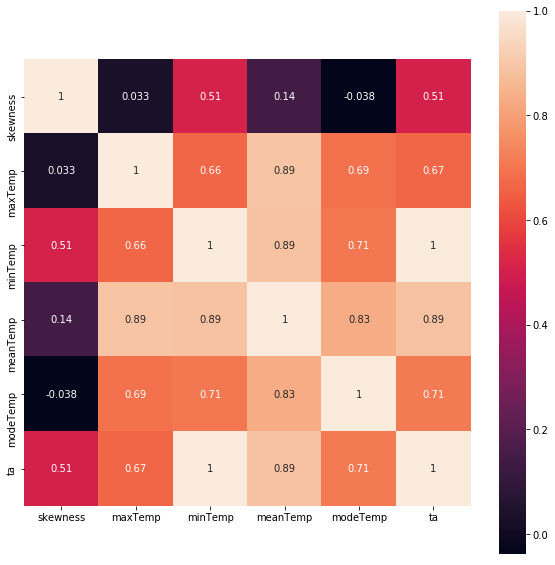

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

featuresCorr = features.corr()
fig = plt.figure(figsize=(10, 10))
# plt.subplots((1,1,1)) # 设置画面大小
sns.heatmap(featuresCorr, annot=True, vmax=1, square=True)
plt.show()

In [77]:
features = features.drop(["maxTemp", "minTemp"], axis=1)

In [78]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
features_scaler = std.fit_transform(features)

In [79]:
df.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            752, 753, 754, 755, 756, 757, 758, 759, 760, 761],
           dtype='int64', length=726)

In [80]:
from sklearn.model_selection import train_test_split

train = features_scaler
target = target_column.values

train_X,test_X, train_y, test_y = train_test_split(train,
                                                   target,
                                                   test_size = 0.1,
                                                   random_state = 0)

In [81]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=2000),
    AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis()
]

for i in classifiers:
    i.fit(train_X, train_y)
    print(i, '\n', cross_val_score(i, test_X, test_y), '\n')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform') 
 [0.69230769 0.75       0.82608696] 

SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 
 [0.57692308 0.83333333 0.82608696] 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 
 [0.80769231 0.83333333 0.86956522] 

GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1), max_iter_predict=100,
             multi_class='one_vs_rest', n_jobs=1, n_restarts_optimizer=0,
             optimizer='fmin_l_bfgs_b', random_state=None,
             warm_start

GaussianProcessClassifier和DecisionTreeClassifier表现比较优异